## <font color='darkblue'>Preface</font>
([article source](https://towardsdatascience.com/a-gentle-introduction-to-self-training-and-semi-supervised-learning-ceee73178b38)) <font size='3ptx'>**Coding an example of self-training in Python to utilize unlabeled data for classification**</font>

**When it comes to machine learning classification tasks, the more data available to train algorithms, the better**. In supervised learning, this data must be labeled with respect to the target class — otherwise, these algorithms wouldn’t be able to learn the relationships between the independent and target variables. **However, there are a couple of issues that arise when building large, labeled data sets for classification:**
* **Labeling data can be time-consuming**: Let’s say we have 1,000,000 dog images that we want to feed to a classification algorithm, with the goal of predicting whether each image contains a Boston Terrier. If we want to use all of those images for a supervised classification task, we need a human to look at each image and determine whether a Boston Terrier is present. While I do have friends (and a wife) who wouldn’t mind scrolling through dog pictures all day, it probably isn’t how most of us want to spend our weekend.
* **Labeling data can be expensive. See reason 1**: to get someone to painstakingly scour 1,000,000 dog pictures, we’re probably going to have to shell out some cash.

So, what if we only have **LIMITED** time and money to label **SOME** of a large data set, and choose to leave the rest unlabeled? Can this unlabeled data somehow be used in a classification algorithm?

**This is where [semi-supervised learning](https://en.wikipedia.org/wiki/Semi-supervised_learning) comes in**. In taking a semi-supervised approach, we can train a classifier on the small amount of labeled data, and then use the classifier to make predictions on the unlabeled data. Since these predictions are likely better than random guessing, the unlabeled data predictions can be adopted as ‘**<font color='darkblue'>pseudo-labels</font>**’ in subsequent iterations of the classifier. While there are many flavors of semi-supervised learning, this specific technique is called <font color='darkblue'>**self-training**</font>.

## <font color='darkblue'>Self-Training</font>
![1.png](images/1.png)
<br/>
On a conceptual level, self-training works like this:
* **Step 1:** Split the labeled data instances into train and test sets. Then, train a classification algorithm on the labeled training data.
* **Step 2:** Use the trained classifier to predict class labels for all of the unlabeled data instances. Of these predicted class labels, the ones with the highest probability of being correct are adopted as ‘<font color='darkblue'>pseudo-labels</font>’.
> (A couple of variations on Step 2: a) All of the predicted labels can be adopted as ‘pseudo-labels’ at once, without considering probability, or b) The ‘pseudo-labeled’ data can be weighted by confidence in the prediction.)

* **Step 3**: Concatenate the ‘pseudo-labeled’ data with the labeled training data. Re-train the classifier on the combined ‘<font color='darkblue'>pseudo-labeled</font>’ and labeled training data.
* **Step 4**: Use the trained classifier to predict class labels for the labeled test data instances. Evaluate classifier performance using your metric(s) of choice.
> (Steps 1 through 4 can be repeated until no more predicted class labels from Step 2 meet a specific probability threshold, or until no more unlabeled data remains.)

Ok, got it? Good! Let’s work through an example.

## <font color='darkblue'>Example: Using Self-Training to Improve a Classifier</font>
To demonstrate self-training, I’m using Python and the **surgical_deepnet** data set, available [here on Kaggle](https://www.kaggle.com/omnamahshivai/surgical-dataset-binary-classification). This data set is intended to be used for binary classification, and contains data for 14.6k+ surgeries. The attributes are measurements like bmi, age, and a variety of others, while the **target variable, complication**, records whether the patient suffered complications as a result of surgery. Clearly, being able to accurately predict whether a patient will suffer complications from a surgery would be in the best interest of healthcare and insurance providers alike.

### <font color='darkgreen'>Imports</font>
For this tutorial, I import numpy, pandas, and matplotlib. I’ll also use the [**LogisticRegression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier from sklearn, as well as the `f1_score` and `plot_confusion_matrix` functions for model evaluation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

### <font color='darkgreen'>Load Data</font>

In [2]:
df = pd.read_csv('../../datas/kaggle_surgical/Surgical-deepnet.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14635 entries, 0 to 14634
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bmi                  14635 non-null  float64
 1   Age                  14635 non-null  float64
 2   asa_status           14635 non-null  int64  
 3   baseline_cancer      14635 non-null  int64  
 4   baseline_charlson    14635 non-null  int64  
 5   baseline_cvd         14635 non-null  int64  
 6   baseline_dementia    14635 non-null  int64  
 7   baseline_diabetes    14635 non-null  int64  
 8   baseline_digestive   14635 non-null  int64  
 9   baseline_osteoart    14635 non-null  int64  
 10  baseline_psych       14635 non-null  int64  
 11  baseline_pulmonary   14635 non-null  int64  
 12  ahrq_ccs             14635 non-null  int64  
 13  ccsComplicationRate  14635 non-null  float64
 14  ccsMort30Rate        14635 non-null  float64
 15  complication_rsi     14635 non-null 

The attributes in the data set are all numerical, and there are no missing values. **Since my focus here isn’t on data cleaning, I’ll move on to partitioning the data.**

### <font color='darkgreen'>Data Splits</font>
To experiment with self-training, I’ll need to **split the data into three parts: a train set, a test set, and an unlabeled set. I’ll split the data according to the following proportions:**
* 1% Train (Labeled)
* 25% Test (Labeled)
* 74% Unlabeled

**For the unlabeled set, I will simply drop the target variable, complication, and pretend that it never existed**. So, in this case, we are imagining that 74% of the surgery cases have no information regarding complications. I do this to simulate the fact that in real-world classification problems, much of the data available may not have class labels. However, if we do have class labels for a small fraction of the data (<font color='brown'>in this case 1%</font>), semi-supervised learning techniques could then be used to draw conclusions from the unlabeled data.

Below, I shuffle the data, generate indices to partition the data, and then create the test, train, and unlabeled splits. I then check the dimensions of the splits to make sure everything went according to plan.

In [3]:
# Shuffle the data
df = df.sample(frac=1, random_state=15).reset_index(drop=True)


# Generate indices for splits
test_ind = round(len(df)*0.25)
train_ind = test_ind + round(len(df)*0.01)
unlabeled_ind = train_ind + round(len(df)*0.74)


# Partition the data
test = df.iloc[:test_ind]
train = df.iloc[test_ind:train_ind]
unlabeled = df.iloc[train_ind:unlabeled_ind]


# Assign data to train, test, and unlabeled sets
X_train = train.drop('complication', axis=1)
y_train = train.complication

X_unlabeled = unlabeled.drop('complication', axis=1)

X_test = test.drop('complication', axis=1)
y_test = test.complication


# Check dimensions of data after splitting
print(f"X_train dimensions: {X_train.shape}")
print(f"y_train dimensions: {y_train.shape}\n")

print(f"X_test dimensions: {X_test.shape}")
print(f"y_test dimensions: {y_test.shape}\n")

print(f"X_unlabeled dimensions: {X_unlabeled.shape}")

X_train dimensions: (146, 24)
y_train dimensions: (146,)

X_test dimensions: (3659, 24)
y_test dimensions: (3659,)

X_unlabeled dimensions: (10830, 24)


### <font color='darkgreen'>Class Distribution</font>

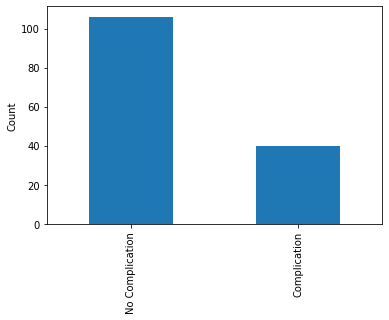

In [4]:
# Visualize class distribution
y_train.value_counts().plot(kind='bar')
plt.xticks([0,1], ['No Complication', 'Complication'])
plt.ylabel('Count');

There are more than twice as many instances of the majority class (<font color='brown'>no complication</font>) than the minority class (<font color='brown'>complication</font>). **With an imbalanced class situation like this, I want to be very selective about the classification evaluation metric that I choose — accuracy may not be the best choice.**

**I choose the F1 score as the classification metric to judge the effectiveness of the classifier**. The F1 score is more robust to class imbalance than accuracy, which is more appropriate when classes are approximately balanced. 

### <font color='darkgreen'>Initial Classifier (Supervised)</font>
To ground-truth the results of semi-supervised learning, I first train a simple Logistic Regression classifier using only the labeled training data, and predict on the test data set.

Train f1 Score: 0.5846153846153846
Test f1 Score: 0.500873616773442


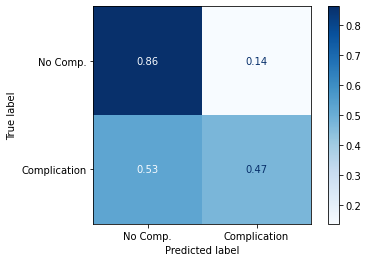

In [5]:
# Logistic Regression Classifier
clf = LogisticRegression(max_iter=1000)

clf.fit(X_train, y_train)
y_hat_test = clf.predict(X_test)
y_hat_train = clf.predict(X_train)

train_f1 = f1_score(y_train, y_hat_train)
test_f1 = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true', display_labels=['No Comp.', 'Complication']);

The classifier has a test F1 score of 0.5. The confusion matrix tells us that the classifier does very well correctly predicting surgeries that did not have complications — 86% accuracy. However, **<font color='darkred'>the classifier has more trouble correctly identifying surgeries with complications, at only 47% accuracy.</font>**

### <font color='darkgreen'>Probability of Predictions</font>
**For the self-training algorithm, we’ll want to know the probabilities of predictions made by the Logistic Regression classifier.** Luckily, sklearn provides the <font color='blue'>.predict_proba()</font> method, which allows us to see the probability of a prediction belonging to either class. As you can see below, the total probability will sum to 1.0 for each prediction in a binary classification problem.

In [7]:
# Generate probabilities for each prediction
probs = clf.predict_proba(X_test)

In [12]:
# https://stackoverflow.com/questions/51740214/find-the-max-from-each-row-in-python/51740298
prob_list = list(np.amax(probs, 1))

In [14]:
prob_list[:20]

[0.9392328646419018,
 0.7671107327539243,
 0.9392328646419018,
 0.9309184774889102,
 0.7525693107878412,
 0.9760601164178976,
 0.9560842077526777,
 0.9392328646419018,
 0.944636513612976,
 0.636376234419445,
 0.9392328646419018,
 0.6450447540361592,
 0.7050385148517285,
 0.9392328646419018,
 0.9678354385717569,
 0.5278497564688398,
 0.6038706632710471,
 0.9552238423159017,
 0.9261718369623576,
 0.9392328646419018]

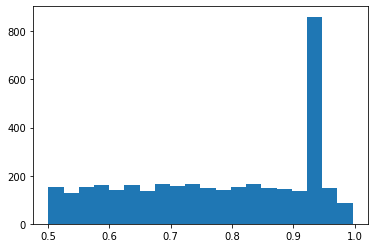

In [16]:
plt.hist(prob_list, bins=20)
plt.show()

### <font color='darkgreen'>Self-Training Classifier (Semi-Supervised)</font>
Now that we know how to get prediction probabilities using sklearn, we can move ahead with coding the self-training classifier. Here is a brief outline:
* **Step 1**: First, train a Logistic Regression classifier on the labeled training data.
* **Step 2**: Next, use the classifier to predict labels for all unlabeled data, as well as probabilities for those predictions. In this case, I will only **adopt ‘pseudo-labels’ for predictions with greater than 99% probability.**
* **Step 3**: Concatenate the ‘pseudo-labeled’ data with the labeled training data, and re-train the classifier on the concatenated data.
* **Step 4**: Use trained classifier to make predictions for the labeled test data, and evaluate the classifier.

Repeat steps 1 through 4 until no more predictions have greater than 99% probability, or no unlabeled data remains.

See the code below for my implementation of these steps in Python, using a while-loop.

In [17]:
# Initiate iteration counter
iterations = 0
prob_threshold = 0.99

# Containers to hold f1_scores and # of pseudo-labels
train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_hat_train = clf.predict(X_train)
    y_hat_test = clf.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1 = f1_score(y_train, y_hat_train)
    test_f1 = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
   
    # Generate predictions and probabilities for unlabeled data
    print(f"Now predicting labels for unlabeled data...")

    pred_probs = clf.predict_proba(X_unlabeled)
    preds = clf.predict(X_unlabeled)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlabeled.index
    
    # Separate predictions with > 99% probability
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > prob_threshold],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > prob_threshold]],
                          axis=0)
    
    print(f"{len(high_prob)} high-probability predictions added to training data.")
    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    y_train = pd.concat([y_train, high_prob.preds])      
    
    # Drop pseudo-labeled instances from unlabeled data
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)
    print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
    # Update iteration counter
    iterations += 1

Iteration 0
Train f1: 0.5846153846153846
Test f1: 0.500873616773442
Now predicting labels for unlabeled data...
42 high-probability predictions added to training data.
10788 unlabeled instances remaining.

Iteration 1
Train f1: 0.7627118644067796
Test f1: 0.5048991354466859
Now predicting labels for unlabeled data...
29 high-probability predictions added to training data.
10759 unlabeled instances remaining.

Iteration 2
Train f1: 0.8157894736842105
Test f1: 0.5060103033772181
Now predicting labels for unlabeled data...
20 high-probability predictions added to training data.
10739 unlabeled instances remaining.

Iteration 3
Train f1: 0.8457142857142856
Test f1: 0.5079726651480639
Now predicting labels for unlabeled data...
20 high-probability predictions added to training data.
10719 unlabeled instances remaining.

Iteration 4
Train f1: 0.8586387434554974
Test f1: 0.5093590470788429
Now predicting labels for unlabeled data...
23 high-probability predictions added to training data.
1069

Iteration 40
Train f1: 0.9475587703435805
Test f1: 0.5262020529443544
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
10083 unlabeled instances remaining.



The self training algorithm went through 40 iterations before no more unlabeled instances could be predicted at >99% probability. Even though there were initially 10,830 unlabeled instances, 10,083 of those remained unlabeled (<font color='brown'>and unused by the classifier</font>) after self-training.

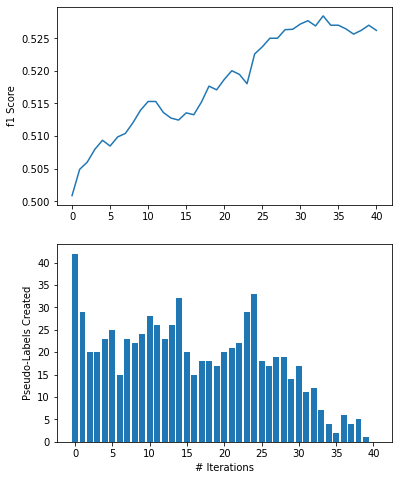

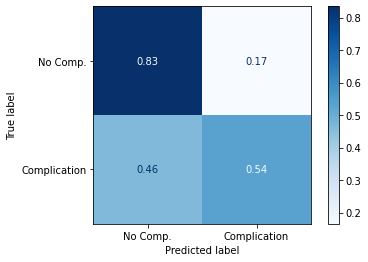

In [18]:
# Plot f1 scores and number of pseudo-labels added for all iterations
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
ax1.plot(range(iterations), test_f1s)
ax1.set_ylabel('f1 Score')
ax2.bar(x=range(iterations), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations');

# View confusion matrix after self-training
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true', display_labels=['No Comp.', 'Complication']);

**Over the 40 iterations, the F1 score improved from 0.50 to 0.525! Though it’s only a small increase, it looks like self-training has improved the classifier’s performance on the test data set**. The top panel of the figure above shows that most of this improvement is happening in earlier iterations of the algorithm. Similarly, the bottom panel shows that most of the ‘pseudo-labels’ added to the training data come during the first 20–30 iterations.

**The final confusion matrix shows an improvement in the classification of surgeries with complications, but <font color='darkred'>a slight decline in the classification of surgeries with no complications</font>**. Supported by the improved F1 score, I think that this is an acceptable improvement — it is likely more important to identify surgery cases that will result in complications (<font color='brown'>True Positives</font>), and it is probably worth increasing the False Positive rate to achieve that result.

## <font color='darkblue'>Words of Caution</font>
So you may be thinking: is there a risk to performing self-training with so much unlabeled data? The answer, of course, is yes. **Remember that although we are including our ‘pseudo-labeled’ data with labeled training data, some of the ‘pseudo-labeled’ data is certainly going to be incorrect. When enough of the ‘pseudo-labels’ are incorrect, the self-training algorithm can reinforce poor classification decisions, and classifier performance can actually get worse**.

However, this risk can be mitigated by following established practices like using a test data set that the classifier has not seen during training, or using a probability threshold for ‘pseudo-label’ prediction.